### EDA of NYC Taxi Fare data in BigQuery Public Dataset and running basic models on it

In [4]:
# Import Libraries
import google.datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

<h3> Quality control and other preprocessing </h3>

We need to do some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

<li>Let's change the BigQuery query appropriately.  In production, we'll have to carry out the same preprocessing on the real-time input data.</li>
<li>Creating data for training. Function can be used to create validation and testing csv as well </li>

In [5]:
def sample_between(a, b):
    basequery = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
    sampler = "AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), EVERY_N) = 1"
    sampler2 = "AND {0} >= {1}\n AND {0} < {2}".format(
           "MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), EVERY_N * 100)",
           "(EVERY_N * {})".format(a), "(EVERY_N * {})".format(b)
        )
    return "{}\n{}\n{}".format(basequery, sampler, sampler2)

def create_query(phase, EVERY_N):
  """Phase: train (70%) valid (15%) or test (15%)"""
  query = ""
  if phase == 'train':
    # Training
    query = sample_between(0, 70)
  elif phase == 'valid':
    # Validation
    query = sample_between(70, 85)
  else:
    # Test
    query = sample_between(85, 100)
  return query.replace("EVERY_N", str(EVERY_N))

print create_query('train', 100)


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 100) = 1
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 100 * 100) >= (100 * 0)
 AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 100 * 100) < (100 * 70)


<h3> Creating CSV files using the query above </h3>
<ol>
<li>3 csv files created</li>
<li> Train, Validation and Test Datasets</li>
</ol>

In [ ]:
def to_csv(df, filename):
  outdf = df.copy(deep = False) #copy by reference
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # Reorder columns so that target is first column
  cols = outdf.columns.tolist() #column names converted into a list
  cols.remove('fare_amount') #just remove target column (fare amount) from column list
  cols.insert(0, 'fare_amount') #added back as first column
  print cols  # new order of columns
  outdf = outdf[cols] #df is reordered
  outdf.to_csv(filename, header = False, index_label = False, index = False) #since row number itself is index
  print "Wrote {} to {}".format(len(outdf), filename)

for phase in ['train', 'valid', 'test']:
  query = create_query(phase, 100)
  df = bq.Query(query).execute().result().to_dataframe()
  to_csv(df, 'taxi-{}.csv'.format(phase))

<li> Check dataset </li>
We have 3 .csv files corresponding to train, valid, test. The ratio of file-sizes correspond to our split of the data.

In [1]:
!ls -l *.csv

-rw-r--r-- 1 root root   2041043 Sep  3 01:34 submission_file.csv
-rw-r--r-- 1 root root  54594507 Sep  3 02:09 taxi-test_10.csv
-rw-r--r-- 1 root root   5561800 Sep  3 01:21 taxi-test.csv
-rw-r--r-- 1 root root 254427262 Sep  3 02:06 taxi-train_10.csv
-rw-r--r-- 1 root root  25255026 Sep  3 01:20 taxi-train.csv
-rw-r--r-- 1 root root  54578047 Sep  3 02:07 taxi-valid_10.csv
-rw-r--r-- 1 root root   5478001 Sep  3 01:21 taxi-valid.csv


In [2]:
%bash
head taxi-test.csv

2.5,Tues,0,-74.062177,40.74634,-74.062182,40.746338,5,notneeded
2.5,Sat,0,-73.983836,40.749462,-73.984234,40.748696,1,notneeded
2.5,Fri,0,-73.948253,40.827172,-73.948253,40.827172,1,notneeded
2.5,Thurs,0,-73.954321,40.774416,-73.864849,40.754235,1,notneeded
2.5,Sun,0,-73.789579,40.646904,-73.78958,40.646903,1,notneeded
2.5,Wed,0,-73.975295,40.759183,-73.97467,40.75878,1,notneeded
2.5,Sat,0,-73.914042,40.744448,-73.913387,40.74433,2,notneeded
2.5,Thurs,0,-73.989878,40.728763,-73.989377,40.729877,5,notneeded
2.5,Sun,0,-74.006815,40.730808,-73.995539,40.74245,1,notneeded
2.5,Sun,0,-73.960835,40.761321,-73.961404,40.76272,1,notneeded


<h3>Simple Benchmark Model</h3>

<li>Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.</li>
<li>Basic model is going to be to simply divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict.</li>
<li>Let's compute the RMSE of such a model.</li>

In [20]:
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

def distance_between(lat1, lon1, lat2, lon2):
  # Haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual - predicted)**2))

def print_rmse(df, rate, name):
  print "{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate * estimate_distance(df)), name) #look at parameters of format 

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers'] #input features
TARGET = 'fare_amount' #prediction label
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key') #row numbers added at last
df_train = pd.read_csv('taxi-train.csv', header = None, names = columns)
df_valid = pd.read_csv('taxi-valid.csv', header = None, names = columns)
df_test = pd.read_csv('taxi-test.csv', header = None, names = columns)

#Calculating trip dist on validation set on which we will predict
df_valid['trip_dist']=estimate_distance(df_valid)
#df_valid = df_valid.loc[df_valid["trip_dist"]<200]

#Training Model
#average rate = average fare / average distance travelled
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print "Rate = ${0}/km".format(rate)

#RMSE using rate calculated above applied to train, validation, test data set
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos


Rate = $3.05868550945/km
Train RMSE = 18.5446689511
Valid RMSE = 18.5216568503
Test RMSE = 18.6157651547


### Plotting function to draw a line with given slope and intercept

In [9]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='r')

### Basic model fitting plot in red on scatter plot of validation set

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


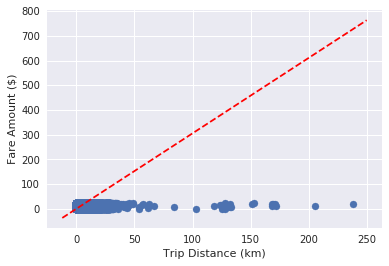

In [10]:
import matplotlib.pyplot as plt
#plt.scatter(x=df_train.loc[0:10000,"trip_dist"],y=df_train.loc[0:10000,"fare_amount"]
plt.scatter(x=df_valid["trip_dist"],y=df_valid["fare_amount"])
#Draw a line parallel to x axis
#plt.axhline(y=rate,color='r')
#Draw line with intercept and slope
abline(rate,0)
plt.xlabel("Trip Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.show()
#ax = sns.scatterplot(x = "trip_dist", y = "fare_amount", data = df_train.loc[1:1000])

In [ ]:
%bash
pwd
ls -lrt

<h1> Using different ML models using Tensorflow</h1>

### Linear Regression

In [12]:
import tensorflow as tf
print(tf.__version__)

1.8.0


<li> We will use the train,valiadation and test csv files created earlier <\li>

In [13]:
# In CSV, label is the first column, after the features, followed by the key
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
FEATURES = CSV_COLUMNS[1:len(CSV_COLUMNS) - 1] #Input features to model
LABEL = CSV_COLUMNS[0] #Output label

#creating data frames
df_train = pd.read_csv('./taxi-train.csv', header = None, names = CSV_COLUMNS)
df_valid = pd.read_csv('./taxi-valid.csv', header = None, names = CSV_COLUMNS)

<h2> Input functions to read from Pandas Dataframe </h2>

In [14]:
def make_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL], #prediction column, LABEL defined above
    batch_size = 128, #number of batches whole df is divided
    num_epochs = num_epochs, #number of times the data is used to train
    shuffle = True, #Each epoch will have a different data arrangement
    queue_capacity = 1000,
    num_threads = 1
  )
#tf.estimator is a library
#pandas_input_fn is a function in the inputs sub library

Our input function for predictions is the same except we don't provide a label

In [15]:
def make_prediction_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = None,
    batch_size = 128,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

### Create feature columns for estimator

In [16]:
def make_feature_cols():
  #Telling tf that the input features are numeric columns
  input_columns = [tf.feature_column.numeric_column(k) for k in FEATURES]#list comprehension
  return input_columns

<h3> Linear Regression with tf.Estimator framework </h3>

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)

#making new dir
OUTDIR = 'taxi_trained'
#In each new rerun remove old dir and make new dir
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model_lr = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)

model_lr.train(input_fn = make_input_fn(df_train, num_epochs = 10))

<h2>Evaluate on the validation data (we should defer using the test data to after we have selected a final model). </h2>
<li>Linear Rgeressor Optimization function:</li>
<li>L = 1/2m * sum(y-Y)^2</li>
<li>RMSE = sqrt(L)</li>

In [ ]:
def print_rmse(model, name, df):
  metrics = model.evaluate(input_fn = make_input_fn(df, 1))
  #different types of metrics in metrics dic, we look at average loss 
  print('RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['average_loss'])))
print_rmse(model_lr, 'validation', df_valid)

### We make prediction on validation dataset next

In [ ]:
#y_predict = model.predict(df_valid)
predictions = model_lr.predict(input_fn = make_prediction_input_fn(df_valid, 1))
predict = []
for i in range(len(df_valid)):
  predict.append(predictions.next()['predictions'][0]) #list
  #print(predictions.next())

In [ ]:
plt.scatter(df_valid["fare_amount"],predict,s=10)
#Plot showing exact prediction
abline(1,0)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.show()

In [ ]:
plt.scatter(df_valid["fare_amount"],predict,s=10)
plt.xlim((0,30))
plt.ylim((10,12.5))
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.show()

Model is predicting around $4 for all.
predictions is a generator object. 
to save predictions make another list and append
<li> This explains why the RMSE was so high -- the model essentially predicts the same amount for every trip. </li>
<li>Would a more complex model help? Let's try using a deep neural network.  The code to do this is quite straightforward as well.</li>

In [ ]:
for k in range(10):
  print predict[k]

<h3> Deep Neural Network regression </h3>

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
model_dnn = tf.estimator.DNNRegressor(hidden_units = [32, 8, 2], #3 hidden layers
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
model_dnn.train(input_fn = make_input_fn(df_train, num_epochs = 100));
print_rmse(model_dnn, 'validation', df_valid)

### Saving predictions from DNN

In [111]:
#y_predict = model.predict(df_valid)
predictions_dnn = model_dnn.predict(input_fn = make_prediction_input_fn(df_valid, 1))
predict_dnn = []
for i in range(len(df_valid)):
  predict_dnn.append(predictions_dnn.next()['predictions'][0]) #list
  #print(predictions.next())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-596742
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


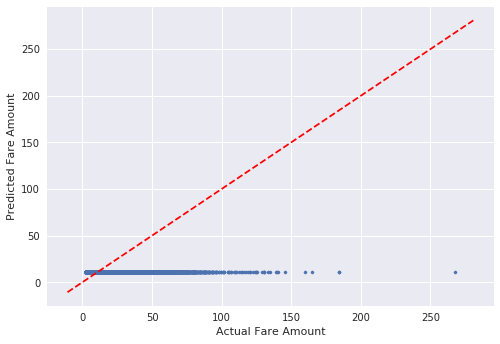

In [112]:
plt.scatter(df_valid["fare_amount"],predict_dnn,s=10)
#Plot showing exact prediction
abline(1,0)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.show()

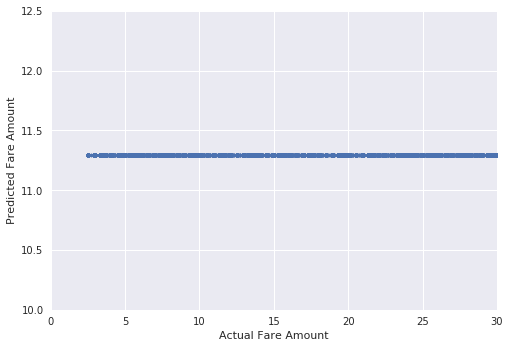

In [113]:
plt.scatter(df_valid["fare_amount"],predict_dnn,s=10)
plt.xlim((0,30))
plt.ylim((10,12.5))
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.show()

So far we have tried three models on this dataset

<li>Simple Basic Model Valid RMSE = 18.5216568503</li>
<li>LinearRegressor Model validation dataset RMSE = 9.49565601349</li>
<li>DNNRegressor Model validation dataset RMSE = 9.49077415466</li>